In [1]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# adds commas to large nums
pd.options.display.float_format = '{:,.2f}'.format

# seaborn plot styles
sns.set_style('darkgrid')
sns.set_context('talk')

In [2]:
df = pd.read_csv('data/final.csv', index_col=0)

# Genre Analysis:

In [3]:
# get list of all genres in df['genre']
genres = sorted(list(set([genre for genres in df['genre'] if isinstance(genres, str) for genre in genres.split()])))
genres.remove('TV')
genres.remove('movie')

# add binary genre cols
for genre in genres:
    df.loc[:, genre] = df['genre'].apply(lambda x: 1 if genre in x.split() else 0)

In [4]:
# get counts of all genres
genre_counts = df.iloc[:, 13:].sum().sort_index().to_frame()
genre_counts.columns = ['count']

# the chance that a movie in our datset is classified as that genre
genre_counts['percent'] = (genre_counts['count'] / df.shape[0])

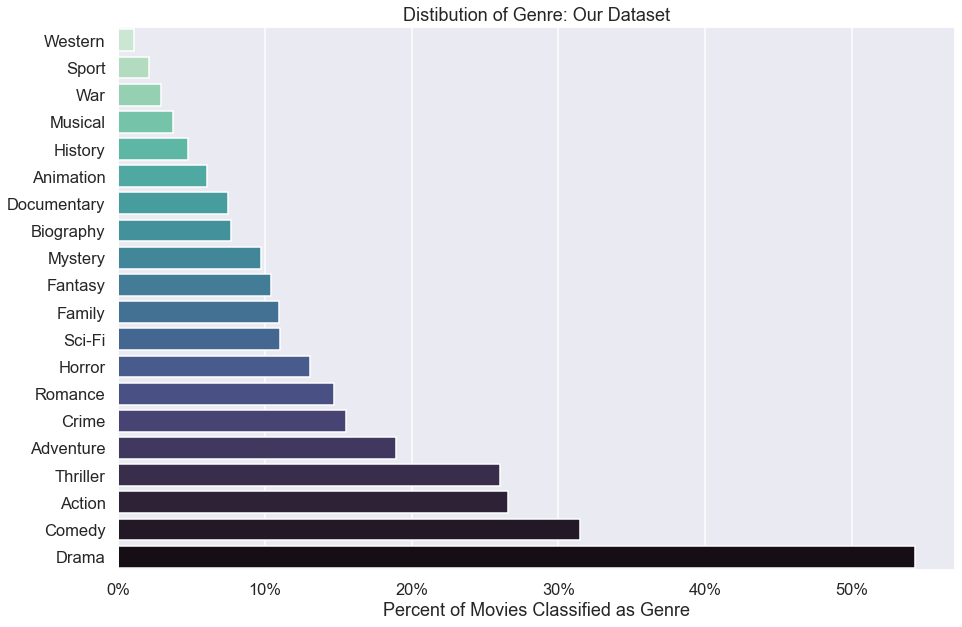

In [5]:
plt.figure(figsize=(15, 10))

sns.barplot(y=genre_counts.sort_values('percent').index, x=genre_counts['percent'].sort_values(), palette='mako_r')

plt.title('Distibution of Genre: Our Dataset')
plt.ylabel('')
plt.xlabel('Percent of Movies Classified as Genre')

plt.xticks(ticks=[0, .10, .20, .30, .40, .50], labels=['0%', '10%', '20%', '30%', '40%', '50%']);

### Bin movies by ROI:
- positive (ROI > 0)
- negative (ROI < 0)
- 100% profit (ROI > 1)

In [6]:
made_money = df.query(" roi > 0 ")
lost_money = df.query(" roi < 0 ")

print(f'We have {made_money.shape[0]} ({made_money.shape[0]/df.shape[0]*100:.1f}%) movies that made money.')
print(f'We have {lost_money.shape[0]} ({lost_money.shape[0]/df.shape[0]*100:.1f}%) movies that lost money.')

We have 1479 (68.6%) movies that made money.
We have 677 (31.4%) movies that lost money.


### Movies that made money:

In [7]:
pos_melted = made_money.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
pos_melted = pos_melted[pos_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

pos_medians = pos_melted.groupby('genre')['roi'].median().to_frame()
pos_medians.columns = ['median_roi']
pos_medians = pos_medians.sort_values('median_roi')

pos_medians.sort_values('median_roi', ascending=False).T

genre,Musical,Horror,Biography,Mystery,Animation,Sci-Fi,War,Romance,Comedy,Documentary,Drama,Thriller,Adventure,Action,Fantasy,Family,Western,Crime,History,Sport
median_roi,3.36,2.84,2.26,2.23,2.21,2.20,2.18,2.11,2.04,1.97,1.93,1.91,1.89,1.83,1.75,1.75,1.73,1.56,1.42,1.24


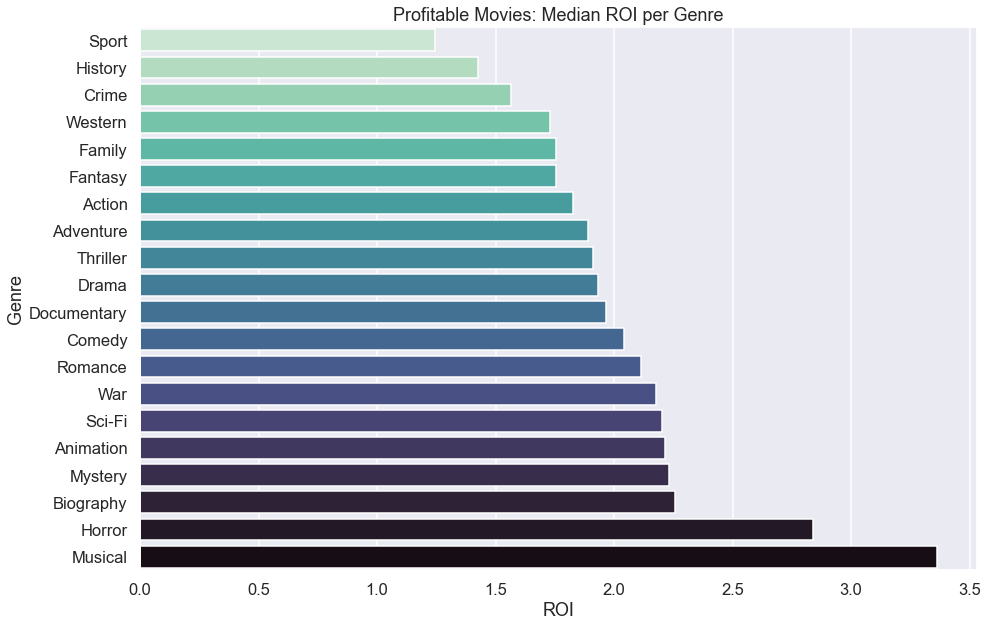

In [8]:
plt.figure(figsize=(15, 10))

sns.barplot(y=pos_medians.index, x=pos_medians['median_roi'], palette='mako_r')

plt.title('Profitable Movies: Median ROI per Genre')
plt.ylabel('Genre')
plt.xlabel('ROI');

In [9]:
# counts of each genre from made_money
pos_counts = pos_melted.groupby('genre')['roi'].count().to_frame().sort_values('roi', ascending=False)
pos_counts.columns = ['count']

# shows what percent of the movies that made money pertained to each genre -> p(genre | profitable)
pos_counts['percent'] = pos_counts['count'] / made_money.shape[0]

### Movies that lost money:

In [10]:
# lost money (negative ROI)
neg_melted = lost_money.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
neg_melted = neg_melted[neg_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

neg_medians = neg_melted.groupby('genre')['roi'].median().to_frame()
neg_medians.columns = ['median_roi']
neg_medians = neg_medians.sort_values('median_roi', ascending=False)

neg_medians.sort_values('median_roi').T

genre,War,Sport,Western,Family,Horror,Documentary,Comedy,Romance,Drama,Action,Biography,Mystery,Thriller,Crime,Sci-Fi,History,Animation,Musical,Fantasy,Adventure
median_roi,-0.78,-0.75,-0.75,-0.74,-0.74,-0.73,-0.71,-0.69,-0.69,-0.69,-0.68,-0.67,-0.67,-0.65,-0.63,-0.62,-0.60,-0.58,-0.56,-0.51


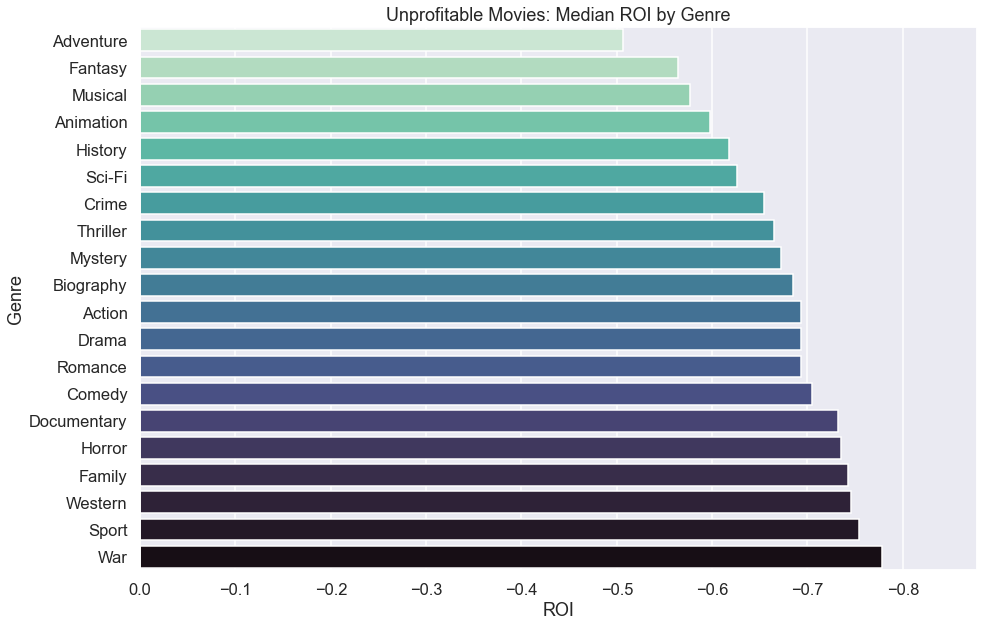

In [11]:
plt.figure(figsize=(15, 10))

plot = sns.barplot(y=neg_medians.index, x=neg_medians['median_roi'], palette='mako_r')
plot.set_xlim(0, min(neg_medians['median_roi']) - 0.1)

plt.title('Unprofitable Movies: Median ROI by Genre')
plt.ylabel('Genre')
plt.xlabel('ROI');

In [12]:
# counts of each genre from lost_money
neg_counts = neg_melted.groupby('genre')['roi'].count().to_frame().sort_values('roi', ascending=False)
neg_counts.columns = ['count']

# shows what percent of the movies that lost money pertained to each genre -> p(genre | unprofitable)
neg_counts['percent'] = neg_counts['count'] / lost_money.shape[0]

neg_counts.T

genre,Drama,Thriller,Comedy,Action,Crime,Romance,Horror,Adventure,Documentary,Biography,Sci-Fi,Mystery,History,Fantasy,Family,Musical,War,Sport,Animation,Western
count,431.00,183.00,181.00,149.00,127.00,105.00,81.00,79.00,65.00,62.00,60.00,56.00,45.00,45.00,37.00,30.00,29.00,20.00,17.00,12.00
percent,0.64,0.27,0.27,0.22,0.19,0.16,0.12,0.12,0.10,0.09,0.09,0.08,0.07,0.07,0.05,0.04,0.04,0.03,0.03,0.02


### What is each genre's chance of being profitable? (profitable | genre)
p(profitable | genre) = (p(genre | profitable) * p(profitable)) / p(genre)

In [13]:
p_genre_given_prof = pos_counts['percent'].sort_index()
p_prof = made_money.shape[0]/df.shape[0]
p_genre = genre_counts['percent'].sort_index()

p_prof_given_genre = ((p_genre_given_prof * p_prof) / p_genre).sort_values(ascending=False).to_frame()

# add a rank col
p_prof_given_genre['percent_rank'] = list(range(1, 21))

p_prof_given_genre.T

genre,Animation,Family,Adventure,Fantasy,Sci-Fi,Action,Comedy,Mystery,Horror,Thriller,Romance,Drama,Musical,Biography,Crime,Documentary,History,Sport,War,Western
percent,0.87,0.84,0.81,0.80,0.75,0.74,0.73,0.73,0.71,0.67,0.67,0.63,0.63,0.63,0.62,0.60,0.56,0.56,0.54,0.50
percent_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [14]:
# for plotting; seperates mulitple-genre films into multiple rows
df_melted = df.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
df_melted = df_melted[df_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

In [15]:
# get median roi for each genre to counter outliers
genre_roi_med = df_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
genre_roi_med.columns = ['median_roi']

# add a rank col
genre_roi_med['median_rank'] = list(range(1, 21))

genre_roi_med.sort_values('median_roi', ascending=False).T

genre,Animation,Family,Adventure,Sci-Fi,Mystery,Horror,Fantasy,Comedy,Action,Biography,Romance,Thriller,Musical,Crime,Drama,Documentary,Sport,War,History,Western
median_roi,1.80,1.46,1.40,1.37,1.36,1.36,1.25,1.21,1.17,0.87,0.86,0.80,0.65,0.61,0.61,0.47,0.47,0.38,0.34,0.18
median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [82]:
# combine median_roi with percent_profitable
combined1 = p_prof_given_genre.merge(genre_roi_med, on='genre')

# composite rank
combined1['agg_rank'] = (combined1['percent'] * combined1['median_roi'])

combined1.T #.sort_values('agg_rank')

genre,Animation,Family,Adventure,Fantasy,Sci-Fi,Action,Comedy,Mystery,Horror,Thriller,Romance,Drama,Musical,Biography,Crime,Documentary,History,Sport,War,Western
percent,0.87,0.84,0.81,0.80,0.75,0.74,0.73,0.73,0.71,0.67,0.67,0.63,0.63,0.63,0.62,0.60,0.56,0.56,0.54,0.50
percent_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00
median_roi,1.80,1.46,1.40,1.25,1.37,1.17,1.21,1.36,1.36,0.80,0.86,0.61,0.65,0.87,0.61,0.47,0.34,0.47,0.38,0.18
median_rank,1.00,2.00,3.00,7.00,4.00,9.00,8.00,5.00,6.00,12.00,11.00,15.00,13.00,10.00,14.00,16.00,19.00,17.00,18.00,20.00
agg_rank,1.56,1.23,1.13,1.00,1.03,0.86,0.89,1.00,0.97,0.54,0.57,0.38,0.41,0.54,0.38,0.28,0.19,0.26,0.21,0.09


### Observations from looking at the genres of ALL movies:
- Animation performs very well. Safest pick with 87% chance of being profitable and it also has the highest median ROI at 1.8.
- Family, Adventure, and Fantasy are also good recs with over 80% chance of profit and median ROI ranks of 2, 3, and 7 respectively.
- Western is by far the worst genre. Ranks 20th in both metrics (only 50% chance of profit and 0.18 median ROI).

### Investigate genre by production_cost:

In [17]:
# movies with production cost less than 10 mil
prod_small = df.query("production_budget < 1e7")
prod_small.shape

(628, 33)

In [50]:
# seperates mulitple-genre films into multiple rows
small_melted = prod_small.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
small_melted = small_melted[small_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

# get median ROi for each genre in prod_small
small_med = small_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
small_med.columns = ['small_median_roi']
small_med['small_median_rank'] = list(range(1, 21))

small_med.T

genre,Animation,Horror,Mystery,Sci-Fi,Biography,Romance,Thriller,Comedy,Family,Fantasy,Drama,Musical,Documentary,Adventure,History,Crime,Western,Action,Sport,War
small_median_roi,2.73,2.29,1.96,0.74,0.68,0.58,0.48,0.48,0.30,0.24,0.21,0.21,0.16,-0.06,-0.11,-0.25,-0.40,-0.42,-0.45,-0.70
small_median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [45]:
# movies with production cost between 10 mil and 100 mil
prod_med = df.query("1e7 <= production_budget < 1e8")
prod_med.shape

(1287, 33)

In [51]:
# seperates mulitple-genre films into multiple rows
med_melted = prod_med.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
med_melted = med_melted[med_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

# get median ROi for each genre in prod_med
med_med = med_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
med_med.columns = ['med_median_roi']
med_med['med_median_rank'] = list(range(1, 21))

med_med.T

genre,Animation,Family,Musical,Comedy,Mystery,Fantasy,Horror,Adventure,Biography,Romance,Sci-Fi,Action,Thriller,Drama,Sport,Crime,Documentary,War,History,Western
med_median_roi,1.53,1.36,1.29,1.29,1.20,1.04,1.04,0.95,0.87,0.86,0.82,0.77,0.74,0.74,0.68,0.63,0.48,0.43,0.37,0.20
med_median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [47]:
# movies with production cost over 100 mil
prod_big = df.query("production_budget >= 1e8")
prod_big.shape

(241, 33)

In [53]:
# seperates mulitple-genre films into multiple rows
big_melted = prod_big.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
big_melted = big_melted[big_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

# get median ROi for each genre in prod_big
big_med = big_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)
big_med.columns = ['big_median_roi']
big_med['big_median_rank'] = list(range(1, 21))

big_med.T

genre,Sport,Crime,Biography,Documentary,Animation,Sci-Fi,Comedy,War,Action,Adventure,Western,Fantasy,Family,Thriller,Romance,Musical,Drama,Mystery,Horror,History
big_median_roi,3.88,2.92,2.90,2.79,2.09,2.05,2.01,2.01,1.95,1.95,1.88,1.88,1.79,1.79,1.77,1.75,1.71,1.64,1.45,-0.10
big_median_rank,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00


In [74]:
combined2 = small_med.merge(med_med, on='genre').merge(big_med, on='genre')

# add composite rank
combined2['agg_rank'] = (combined['small_median_rank'] + combined['med_median_rank'] + combined['big_median_rank']) / 3

combined2.sort_values('agg_rank').T

genre,Animation,Biography,Comedy,Sci-Fi,Family,Mystery,Fantasy,Horror,Romance,Musical,Adventure,Documentary,Crime,Thriller,Sport,Action,Drama,War,Western,History
small_median_roi,2.73,0.68,0.48,0.74,0.30,1.96,0.24,2.29,0.58,0.21,-0.06,0.16,-0.25,0.48,-0.45,-0.42,0.21,-0.70,-0.40,-0.11
small_median_rank,1.00,5.00,8.00,4.00,9.00,3.00,10.00,2.00,6.00,12.00,14.00,13.00,16.00,7.00,19.00,18.00,11.00,20.00,17.00,15.00
med_median_roi,1.53,0.87,1.29,0.82,1.36,1.20,1.04,1.04,0.86,1.29,0.95,0.48,0.63,0.74,0.68,0.77,0.74,0.43,0.20,0.37
med_median_rank,1.00,9.00,4.00,11.00,2.00,5.00,6.00,7.00,10.00,3.00,8.00,17.00,16.00,13.00,15.00,12.00,14.00,18.00,20.00,19.00
big_median_roi,2.09,2.90,2.01,2.05,1.79,1.64,1.88,1.45,1.77,1.75,1.95,2.79,2.92,1.79,3.88,1.95,1.71,2.01,1.88,-0.10
big_median_rank,5.00,3.00,7.00,6.00,13.00,18.00,12.00,19.00,15.00,16.00,10.00,4.00,2.00,14.00,1.00,9.00,17.00,8.00,11.00,20.00
agg_rank,2.33,5.67,6.33,7.00,8.00,8.67,9.33,9.33,10.33,10.33,10.67,11.33,11.33,11.33,11.67,13.00,14.00,15.33,16.00,18.00


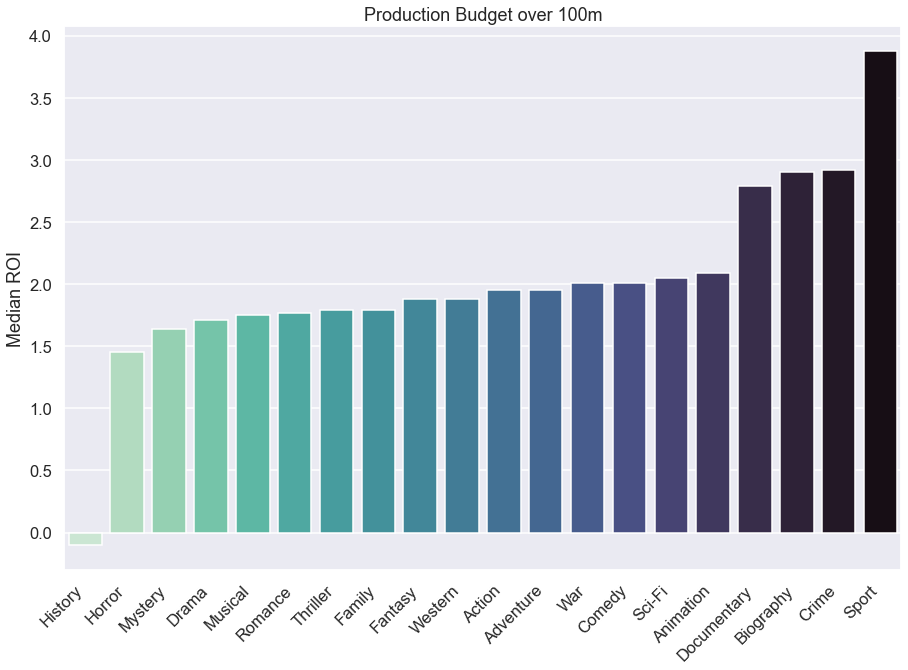

In [69]:
# plot for big production films
plt.figure(figsize=(15, 10))

sns.barplot(x=combined.sort_values('big_median_roi').index, y=combined.sort_values('big_median_roi')['big_median_roi'], palette='mako_r')

plt.title('Production Budget over 100m')
plt.ylabel('Median ROI')
plt.xlabel('')

plt.xticks(rotation=45)

for label in plt.gca().get_xticklabels():
    label.set_horizontalalignment('right')
    
plt.savefig('plots/roi_over_100', dpi=150);

### Final Genre Recs:
- Animation is king. Safest and most profitable overall. #1 rank for small and medium budget films.
- Family and Adventure are honorable mentions.
- Sport performed extremely well when given a large budget.